# Pneumonia detection

        TODO: ADD More info...

Imports

In [12]:
'''
    Run this in case the following imports don't run.
    !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
'''
import time
import copy
import os
import cv2
import random

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import torch
from torch import optim
from torch.utils.data import DataLoader

from torchvision import transforms, datasets, models


Parameters

In [2]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper Parameters
n_epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 32
learn_rate = 0.001

# Paths
dir_data = "/content/drive/MyDrive/Colab Notebooks/pneumonia/file/chest_xray"
dir_val = os.path.join(dir_data, 'val')
dir_test =  os.path.join(dir_data, 'test')
dir_train =  os.path.join(dir_data, 'train')
dir_train_normal = os.path.join(dir_train, 'NORMAL')
dir_train_pneumonia = os.path.join(dir_train, 'PNEUMONIA')

path_model = os.path.join(dir_data, 'classifier.pt')

## Prepare data

#### Colab only...

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data augmentation

In [3]:
'''
    TODO: 2022-06-22 - What mean all these parameter values?
'''

# Train: Transform sequence 01
transf_train = transforms.Compose([
    transforms.Resize(60),
    transforms.RandomCrop(54),
    transforms.ToTensor(), # Converts pixels [0-255] to tensors [0-1] TODO: Understand it
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Train: Transform sequence 02
# transf_train2 = transforms.Compose([
#     transforms.Resize(57),
#     transforms.RandomRotation(10),
#     transforms.RandomCrop(54),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Test & Validation: Transform sequence
transf_test = transforms.Compose([
    transforms.Resize(54),
    transforms.CenterCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

### Load dataset

In [4]:

'''
    TODO: 2022-06-22 - Figure balancing out
    # criando 2 sets de treinamento para mesclar os dois e balancear as classes
'''

# Datasets
ds_train1 = datasets.ImageFolder(dir_train, transform=transf_train)
# ds_train2 = datasets.ImageFolder(dir_train, transform=transf_train2)
ds_validation = datasets.ImageFolder(dir_val, transform=transf_test)
ds_test = datasets.ImageFolder(dir_test, transform=transf_test)

# Data loaders
loader_train = DataLoader(ds_train1, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)
loader_validation = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)

print('(size) loader_train: {}'.format(len(loader_train)))
print('(size) loader_test: {}'.format(len(loader_test)))
print('(size) loader_validation: {}'.format(len(loader_validation)))
print('-' * 80)

# Create new validation set TODO: Figure this out!
# trainset, validset = train_test_split(trainset, test_size=0.2)

# See what we've done
n_train = len(ds_train1)
n_test = len(ds_test)
n_validation = len(ds_validation)

class_names = ds_train1.classes
images, labels = iter(loader_train).next()

print('Train: {} images, Test: {} images, Validation: {} images'.format(n_train, n_test, n_validation))
print('Classes: ' + str(ds_train1.class_to_idx))
print('Images shape: {}'.format(str(images.shape))) # torch.Size([32, 3, 54, 54])
print('Labels shape: {}'.format(str(labels.shape))) # torch.Size([32])


(size) loader_train: 163
(size) loader_test: 20
(size) loader_validation: 1
--------------------------------------------------------------------------------
Train: 5216 images, Test: 624 images, Validation: 16 images
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Images shape: torch.Size([32, 3, 54, 54])
Labels shape: torch.Size([32])


In [12]:
# ds_train1
# ds_test
# ds_validation
# loader_validation
loader_train

### Data Balancing
    > TODO...

#### See data: Unbalanced Distribution

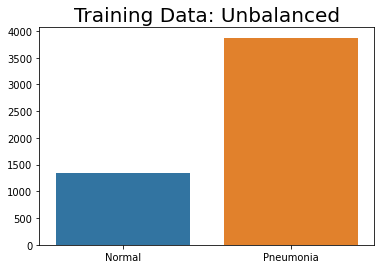

In [12]:
files_normal = [os.path.join(dir_train_normal, file) for file in os.listdir(dir_train_normal)]
files_pneumonia = [os.path.join(dir_train_pneumonia, file) for file in os.listdir(dir_train_pneumonia)]
df_train_unbalanced = pd.DataFrame.from_dict({ 'Normal': [len(files_normal)], 'Pneumonia': [len(files_pneumonia)] })

sns.barplot(data=df_train_unbalanced).set_title('Training Data: Unbalanced', fontsize=20)
plt.show()

#### Run Balancing

TODO: 2022-06-22 - Figure this out!

In [ ]:
#balanceando as classes
#trainset2, _ = train_test_split(trainset2, test_size= 3875/train_size, shuffle=False)
#trainset = ConcatDataset([trainset, trainset2])

### See our images

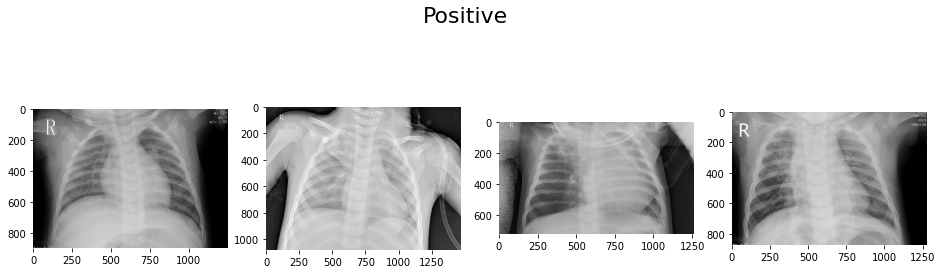

In [13]:
img_paths = os.listdir(dir_train_pneumonia)
random.shuffle(img_paths)

fig = plt.figure(figsize=(16, 5))
fig.suptitle("Positive", size=22)

for i, image in enumerate(img_paths[:4]):
    img_path = os.path.join(dir_train_pneumonia, image)
    img = cv2.imread(img_path)
    plt.subplot(1, 4, i + 1, frameon=False)
    plt.imshow(img)
fig.show()

## Build Model


### Model backbone: resnet18, pretrained

- Backbone _(feature extractor)_: __Resnet__
- We use pre-trained weights of Resnet (from `torch.models`) to increase accuracy & reduce training time.


In [5]:

'''
	NOTE: We need to replace the original last layer
	- Last layer is a linear fully connected one with many outputs;
	- Our net needs 02 (as we have 02 classes);
	- We replace it so it becomes a binary classifier;
	- We end up with a new last layer holding the same number of inputs but only 02 outputs:
	
	NOTE: The end network has no activation function
	- For our binary classification we'd need a sigmoid activation;
	- But we skip this job as our cost function already handles this; TODO: Figure this out!
'''

model = models.resnet18(pretrained=True)
for params in model.parameters():	# Freeze parameters (so pre-trained convolution layers don't change)
	params.requires_grad_ = False

n_filters = model.fc.in_features
model.fc = torch.nn.Linear(n_filters, 2) # Replace last layer
model = model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training

#### Train

In [7]:
since = time.time()
best_model = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    
    # Train
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(loader_train, total=len(loader_train)):
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, y_hat = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0) # TODO: Figure this out
        running_corrects += torch.sum(y_hat == labels.data)
        
    epoch_loss = running_loss / n_train
    epoch_accuracy = running_corrects.double() / n_train
    print('Train Loss: {:.4f}; Train Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
    
    # Validate
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader_validation:
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, y_hat = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0) # TODO: Figure this out
        running_corrects += torch.sum(y_hat == labels.data)

    epoch_loss = running_loss / n_validation
    epoch_accuracy = running_corrects.double() / n_validation
    print('Val Loss: {:.4f}; Val Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
    print('-' * 30)
    
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model = copy.deepcopy(model.state_dict())
    
time_elapsed = time.time() - since
model.load_state_dict(best_model)

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best Val Acc: {:.4f}'.format(best_accuracy))

Epoch 1/4


100%|██████████| 163/163 [03:59<00:00,  1.47s/it]


Train Loss: 0.1566; Train Accuracy: 0.9469
Val Loss: 0.4356; Val Accuracy: 0.6875
------------------------------
Epoch 2/4


100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


Train Loss: 0.0967; Train Accuracy: 0.9632
Val Loss: 0.6633; Val Accuracy: 0.6875
------------------------------
Epoch 3/4


100%|██████████| 163/163 [04:00<00:00,  1.48s/it]


Train Loss: 0.0744; Train Accuracy: 0.9735
Val Loss: 0.3428; Val Accuracy: 0.9375
------------------------------
Epoch 4/4


100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


Train Loss: 0.0663; Train Accuracy: 0.9757
Val Loss: 0.9342; Val Accuracy: 0.5625
------------------------------
Training complete in 16m 6s
Best Val Acc: 0.9375


#### Save classifier

In [8]:
torch.save(model.state_dict(), path_model)

## Evaluation

#### Test

In [10]:
was_training = model.training
model.eval()

labels = []
predictions = []
n_successes = 0

with torch.no_grad():
    for i in range(n_test):
        input, label = ds_test[i]
        input = input[np.newaxis, :] # Turn into row vector (add 1D)
        input = input.to(DEVICE)
        
        output = model(input)
        _, y_hat = torch.max(output, 1)
        
        label_real = class_names[label]
        label_hat = class_names[y_hat]
        if label_hat == label_real:
            n_successes += 1
        
        labels.append(label_real)
        predictions.append(label_hat)

model.train(mode=was_training)

accuracy = n_successes / n_test
print('Test Accuracy: {:.4f}'.format(accuracy))

Test Accuracy: 0.9119


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Confusion Matrix

<Figure size 432x288 with 0 Axes>

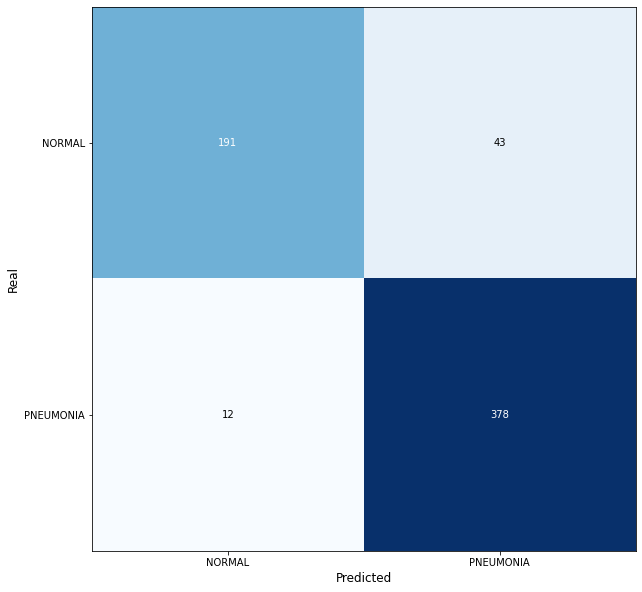

In [17]:
matrix = confusion_matrix(labels, predictions)

plt.figure()
plot_confusion_matrix(matrix, figsize=(10,10))
plt.xticks(range(2), class_names, fontsize=10)
plt.yticks(range(2), class_names, fontsize=10)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()